In [1]:
import numpy as np
import collections
import csv
import pandas

import matplotlib.cm

import matplotlib.pylab as plt
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

from IPython.display import display, HTML
%pylab --no-import-all
%matplotlib inline


fordgobike_csv = "2017-fordgobike-tripdata.csv"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load and Format Data

In [2]:

dtypes = {
    'duration_sec': 'float',
    'start_time': 'str',
    'end_time': 'str',
    'start_station_id': 'int',
    'start_station_name': 'str',
    'start_station_latitude': 'float',
    'start_station_longitude': 'float',
    'end_station_id': 'int',
    'end_station_name': 'str',
    'end_station_latitude': 'float',
    'end_station_longitude': 'float',
    'bike_id': 'int',
    'user_type': 'str',
    'member_birth_year': 'float',
    'member_gender': 'str'
}

parse_dates = ['start_time', 'end_time']
data = pandas.read_csv(fordgobike_csv, dtype=dtypes, parse_dates=parse_dates)

In [3]:
# dayofweek is interger, weekday_name is string
# 0 is Monday, 6 is Sunday
data['start_day_of_week'] = data['start_time'].dt.dayofweek
data['start_time_of_day'] = data['start_time'].dt.time
data['end_day_of_week'] = data['end_time'].dt.dayofweek
data['end_time_of_day'] = data['end_time'].dt.time

# Understand Data about Bike Stations and Trips

Number of stations:  272
Number of bikes:  3673
Number of trips:  519700


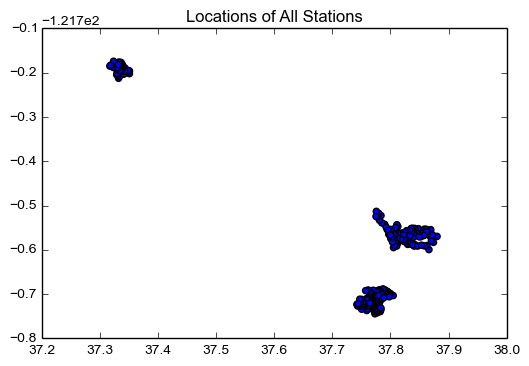

In [145]:
station_ids = set(data['start_station_id']) | set(data['end_station_id'])
bike_ids = set(data['bike_id'])

stations = {}
print 'Number of stations: ', len(station_ids)
print 'Number of bikes: ', len(bike_ids)
print 'Number of trips: ', data.shape[0]

for _, row in data.iterrows():
  sid = row['start_station_id']
  if sid not in stations:
    lat = row['start_station_latitude']
    log = row['start_station_longitude']
    stations[sid] = [lat, log]
  sid = row['end_station_id']
  if sid not in stations:
    lat = row['end_station_latitude']
    log = row['end_station_longitude']
    stations[sid] = [lat, log]

station_array = []
for sid, pos in stations.iteritems():
  station_array.append([sid, pos[0], pos[1]])
station_array = np.array(station_array)

plt.scatter(station_array[:, 1], station_array[:, 2])
plt.title('Locations of All Stations')
plt.show()

## Cluster the Bike Stations

In [5]:
from sklearn.cluster import KMeans

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=3, random_state=0).fit(station_array[:, 1:])
kmeans.cluster_centers_

station_clusters = [station_array[kmeans.labels_ == c] for c in xrange(num_clusters)]
station_array = numpy.concatenate([station_array, numpy.expand_dims(kmeans.labels_, -1).astype(float)], axis=1)

In [9]:
import collections

cluster2stations = collections.defaultdict(list)
station2cluster = {}
for s in xrange(station_array.shape[0]):
  cluster2stations[station_array[s, 3]].append(station_array[s, 0])
  station2cluster[station_array[s, 0]] = station_array[s, 3]

cross_region_trips = 0
trips_in_cluster = collections.defaultdict(lambda: 0)
for _, row in data.iterrows():
  if station2cluster[row['start_station_id']] != station2cluster[row['end_station_id']]:
    cross_region_trips += 1
  else:
    trips_in_cluster[station2cluster[row['start_station_id']]] += 1

print '%d out of %d trips are cross-regional.' % (cross_region_trips, data.shape[0])
print '# of trips per cluster are %s' % trips_in_cluster.values()

68 out of 519700 trips are cross-regional.
# of trips per cluster are [18260, 90067, 411305]


## Show Stations in Each Region

In [88]:
def BBox(station_array):
  bbox = [
      numpy.min(station_array[:, 1]),
      numpy.max(station_array[:, 1]),
      numpy.min(station_array[:, 2]),
      numpy.max(station_array[:, 2]),
  ]
  return bbox

def PlotMap(bbox, resolution='i', draw=True):
    center_lat = (bbox[0] + bbox[1]) * 0.5
    center_log = (bbox[2] + bbox[3]) * 0.5
    fig, ax = plt.subplots(figsize=(5,5))
    m = Basemap(resolution=resolution, # c, l, i, h, f or None
                projection='merc',
                lat_0=center_lat, lon_0=center_log,
                llcrnrlon=bbox[2], llcrnrlat=bbox[0], urcrnrlon=bbox[3], urcrnrlat=bbox[1])
    if draw:
      m.drawmapboundary(fill_color='#46bcec')
      m.drawcoastlines()
      m.fillcontinents(color='#f2f2f2',lake_color='#46bcec', zorder=0)
    return m

from datetime import date, datetime, time

def DiffTime(start_time, end_time):
  return (datetime.combine(date.min, end_time) - datetime.combine(date.min, start_time)).total_seconds()

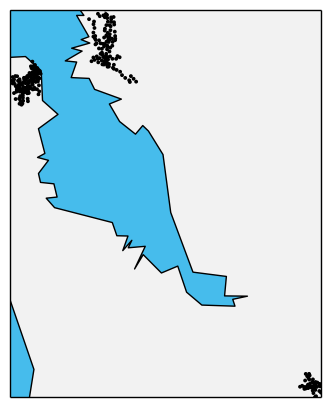

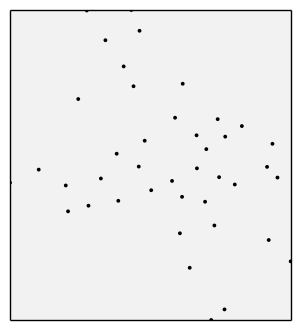

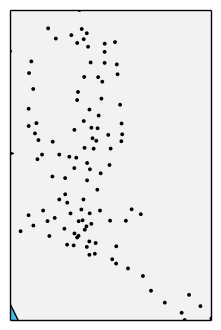

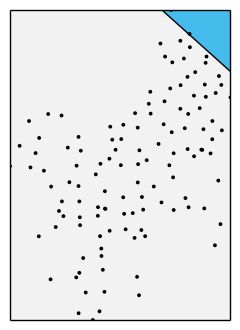

In [83]:
fig, ax = plt.subplots(figsize=(5,5))
m = PlotMap(BBox(station_array), 'i')
x, y = m(station_array[:, 2], station_array[:, 1])
plt.scatter(x, y, 3, marker='o',color='k')
plt.show()

for c in xrange(num_clusters):
  m = PlotMap(BBox(station_clusters[c]), 'i')
  x, y = m(station_clusters[c][:, 2], station_clusters[c][:, 1])
  plt.scatter(x, y, 3, marker='o',color='k')
  plt.show()

## Understand Trip Duration
Most of the trips are under 30 min, and almost all trips are under 1 hour

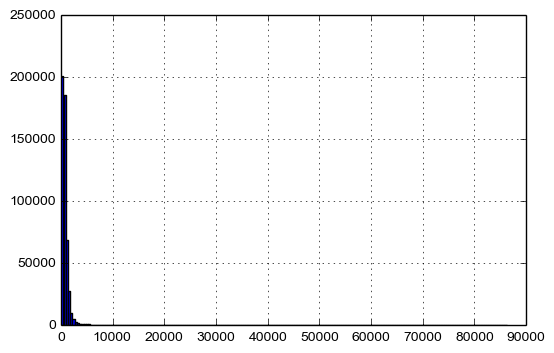

In [8]:
data['duration_sec'].hist(bins=200)

## Prepare Data for Further Time-Sequence Analysis

In [140]:
class TimeSlotStation:
    def __init__(self, num_bins, start_bin=0, end_bin=None):
        self._start_bin = start_bin
        self._end_bin = end_bin if end_bin else num_bins
        self._takens = numpy.zeros((self._end_bin - start_bin,))
        self._returns = numpy.zeros((self._end_bin - start_bin,))
        
    def Take(self, time_bin):
        if time_bin < self._start_bin or time_bin >= self._end_bin:
            return
        self._takens[time_bin - self._start_bin] += 1
        
    def Return(self, time_bin):
        if time_bin < self._start_bin or time_bin >= self._end_bin:
            return
        self._returns[time_bin - self._start_bin] += 1
        
    def NumTakensAt(self, time_bin):
        if time_bin < self._start_bin or time_bin >= self._end_bin:
            return
        return self._takens[time_bin - self._start_bin]
    
    def NumReturnsAt(self, time_bin):
        if time_bin < self._start_bin or time_bin >= self._end_bin:
            return
        return self._returns[time_bin - self._start_bin]
    
    def Takens(self):
        return self._takens
    
    def Returns(self):
        return self._returns

class TimeSlotTrip:
    def __init__(self, num_bins):
        self.count = numpy.zeros((num_bins,))

def TimeToBin(time_of_day, interval):
    begin_of_day = time()
    bin_id = int(DiffTime(begin_of_day, time_of_day) / interval)
    return bin_id

def AggregateByTimeSlots(data, num_bins_per_day, start_bin=0, end_bin=None):
    interval = 3600 * 24 / num_bins_per_day
    station_events = collections.defaultdict(
        lambda: collections.defaultdict(lambda: TimeSlotStation(num_bins_per_day, start_bin, end_bin)))
    trip_events = collections.defaultdict(
        lambda: collections.defaultdict(lambda: TimeSlotTrip(num_bins_per_day)))

    for _, row in data.iterrows():
        start_sid = row['start_station_id']
        end_sid = row['end_station_id']
        start_day_of_week = row['start_day_of_week']
        end_day_of_week = row['end_day_of_week']

        time_bin = TimeToBin(row['start_time_of_day'], interval)
        station_events[start_day_of_week][start_sid].Take(time_bin)
        time_bin = TimeToBin(row['end_time_of_day'], interval)
        station_events[end_day_of_week][end_sid].Return(time_bin)
        trip_events[start_sid][end_sid].count[time_bin] += 1

    return station_events, trip_events

In [141]:
station_events, trip_events = AggregateByTimeSlots(data, 48)

## Get Intuitation about How Bikes are Taken and Returned.

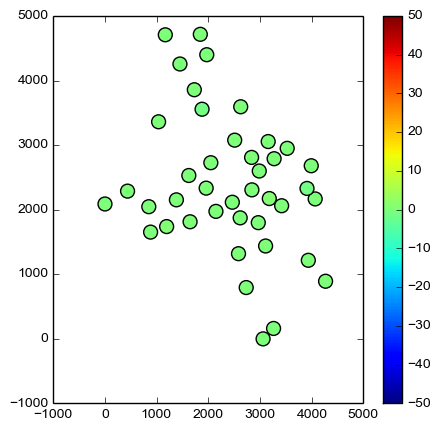

Hour of the day:  5.25


In [136]:
from matplotlib import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

time_bin = 22


def UpdateStations(time_bin, region, dayofweek, max_number):
    
    m = PlotMap(BBox(station_clusters[region]), 'l', draw=False)
    sids = station_clusters[region][:, 0]
    taken_rate = numpy.array(
          [station_events[dayofweek][sid].NumTakensAt(time_bin) -
           station_events[dayofweek][sid].NumReturnsAt(time_bin)
           for sid in sids])
    x, y = m(station_clusters[region][:, 2],
             station_clusters[region][:, 1])
    sc = plt.scatter(x, y, 100, marker='o', c=taken_rate, cmap=cm.jet,
                     vmin=-max_number, vmax=max_number)
    plt.colorbar(sc)
    plt.show()
    print "Hour of the day: ", interval * (time_bin + 0.5) / 3600.0

interact(UpdateStations,
         time_bin=widgets.IntSlider(min=0,max=num_bins_per_day-1,step=1,value=10),
         region=widgets.IntSlider(min=0,max=2,step=1,value=0),
         dayofweek=widgets.IntSlider(min=0,max=6,step=1,value=0),
         max_number=widgets.IntSlider(min=10,max=60,step=10,value=50));


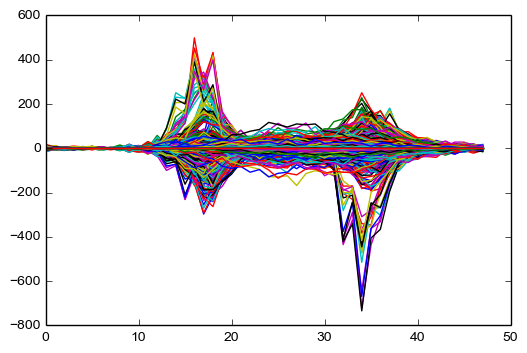

In [142]:
for day, day_events in station_events.iteritems():
  for sid, stats in day_events.iteritems():
    plt.plot(stats.Takens())
    plt.plot(-stats.Returns())

## Group Trips in Coarser Granularity Accordingly to Reduce Dimentionality

In [172]:
station_events, trip_events = AggregateByTimeSlots(data, 12, start_bin=3, end_bin=11)
#station_events, trip_events = AggregateByTimeSlots(data, 48)

In [173]:
time_series = []
for day_of_week, day_stats in station_events.iteritems():
    for sid, stats in day_stats.iteritems():
        time_series.append(numpy.concatenate([stats.Takens(), -stats.Returns()]))
time_series = numpy.array(time_series)
print time_series.shape

(1881, 16)


[ 0.30738704  0.13178967  0.06894385  0.05321966  0.03316698  0.02789224
  0.02495424  0.02288469  0.02178939  0.01864639  0.0166607   0.01620647
  0.01439951  0.01353882  0.01288532  0.01269628  0.01221874  0.0117109
  0.01133354  0.01088685  0.01075663  0.01034062  0.00984326  0.00975106
  0.0096358   0.00928021  0.00921576  0.00898676  0.00880482  0.00844336
  0.00836461  0.00830341  0.00814404  0.0080645   0.00797038  0.00781698
  0.0077194   0.00763765  0.00747314  0.00738888  0.0073205   0.00713277
  0.00709173  0.00693576  0.00684043  0.00681455  0.00677149  0.00666641
  0.00655101  0.00642112  0.00629715  0.00622388  0.00608566  0.00598147
  0.00592591  0.00583989  0.00565353  0.00564111  0.0053742   0.00519646
  0.00506947  0.00499743  0.00475287  0.00456895  0.0043718   0.00429688
  0.00421119  0.00395039  0.00382004  0.00369286  0.00358409  0.00328261
  0.00316424  0.00307968  0.00275962  0.00270771  0.0025311   0.00232312
  0.00216368  0.00203994  0.00193971  0.00184964  0.

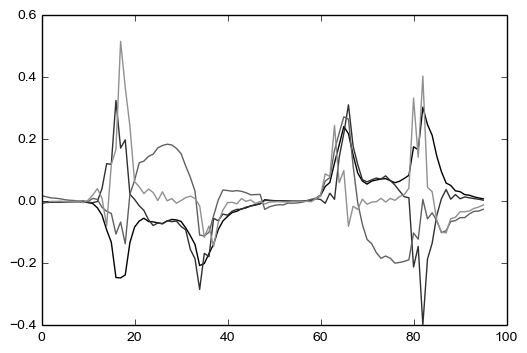

In [171]:
u, s, v = numpy.linalg.svd(time_series, full_matrices=0, compute_uv=1)
count = 4
for i in xrange(4):
  plt.plot(v[i, :], color=cm.gray(float(i) / count * 0.75))
plt.show()

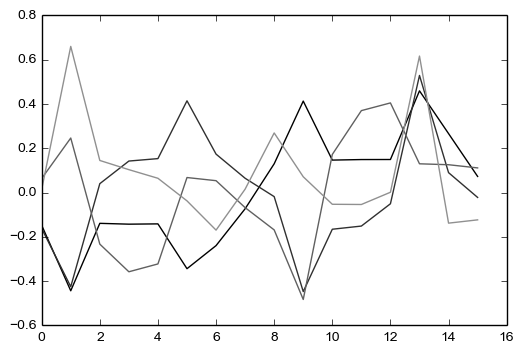

In [174]:
u, s, v = numpy.linalg.svd(time_series, full_matrices=0, compute_uv=1)
count = 4
for i in xrange(4):
  plt.plot(v[i, :], color=cm.gray(float(i) / count * 0.75))
plt.show()

## Can the bikes be restored at each station?

## What are the typical usages patterns for each station?

## What is a good time to move bikes around, how many and from where to where?

## Are there useless stations?

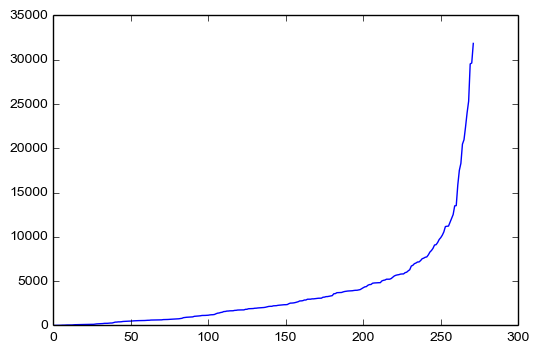

In [180]:
usages = collections.defaultdict(lambda: 0)
for day_of_week, day_stats in station_events.iteritems():
    for sid, stats in day_stats.iteritems():
        usages[sid] += numpy.sum(stats.Takens()) + numpy.sum(stats.Returns())
usage_array = numpy.array(usages.values())
usage_array.sort()
plt.plot(usage_array)

In [11]:
f=open(fordgobike_csv,"r")
data=list(csv.reader(f))
header=data[0]
data=data[1:]
print(header)
print(data[1])

['duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'member_birth_year', 'member_gender']
['78800', '2017-12-31 15:56:34.8420', '2018-01-01 13:49:55.6170', '284', 'Yerba Buena Center for the Arts (Howard St at 3rd St)', '37.78487208436062', '-122.40087568759917', '96', 'Dolores St at 15th St', '37.7662102', '-122.4266136', '88', 'Customer', '1965', 'Female']


3673
519700
{'': 66462, 'Male': 348318, 'Other': 6299, 'Female': 98621}


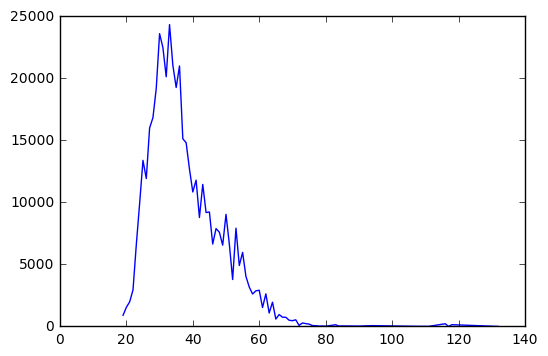

In [3]:
def column_unique(data, index):
    column_unique={}
    for row in data:
        if row[index] in column_unique:
            column_unique[row[index]]+=1
        else:
            column_unique[row[index]]=1
    return column_unique
bike_id_unique=column_unique(data,11)
print(len(bike_id_unique))
print(len(data))
gender_unique=column_unique(data,14)
print(gender_unique)
birthyear_unique=column_unique(data,13)
age_list={}
for i,k in birthyear_unique.iteritems():
    try:
        age = 2018-int(i)
    except:
        continue
    age_list[age]=k

import matplotlib.pylab as plt
plt.plot(*zip(*sorted(age_list.items())))
plt.show()


plt.bar(range(len(age_list)), list(age_list.values()), align='center')
plt.xticks(range(len(age_list)), list(age_list.keys()))

plt.show()

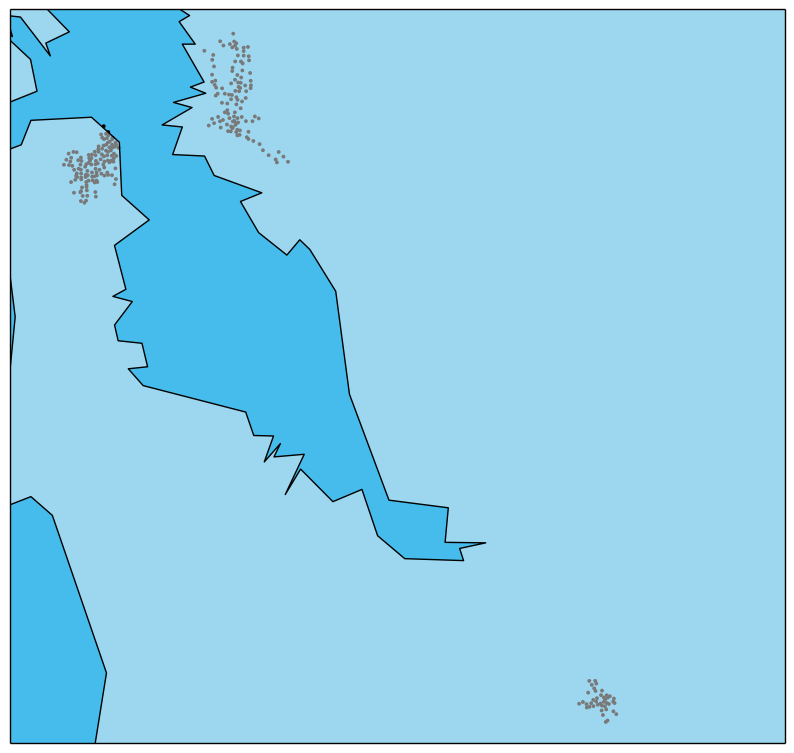

In [44]:
import matplotlib.cm

import matplotlib.pylab as plt
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,10))

m = Basemap(resolution='i', # c, l, i, h, f or None
            projection='merc',
            lat_0=37.75, lon_0=-122.1,
            llcrnrlon=-122.5, llcrnrlat= 37.3, urcrnrlon=-121.7, urcrnrlat=37.9)
m.scatter(x, y, 3, marker='o',color='k')
m.drawmapboundary(fill_color='#46bcec')
m.drawcoastlines()
x, y = m(station_array[:, 2], station_array[:, 1])
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec', alpha=0.5)
plt.show()

In [ ]:
feedbacks = pandas.read_csv(fordgobike_csv)
for _, row in feedbacks.iterrows():
      match_id = row['match_id']
      week_id = row['week_id']
      meeting_id = '%d_%d' % (week_id, match_id)
      matches[meeting_id][row['user_id']] = {
          'rating': row['rating'],
          'reason': row['reason'],
          'week': week_id,
          'meeting_id': match_id
      }